In [1]:
from simple_unet import multi_unet_model #Uses softmax 

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from tqdm import tqdm 


2022-05-26 13:06:39.314812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 13:06:39.314838: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Resizing images, if needed
SIZE_X = 512
SIZE_Y = 512
n_classes= 3 #Number of classes for segmentation

TRAIN_PATH_X = '/home/khamituly/Documents/defense/common_patients/temp/'
TRAIN_PATH_Y = '//home/khamituly/Documents/defense/common_patients/y/'

#512
# IMG_WIDTH = 512
# IMG_HEIGHT = 512
# IMG_CHANNELS = 3
train_ids_x = next(os.walk(TRAIN_PATH_X))[2]
train_ids_y = next(os.walk(TRAIN_PATH_Y))[2]

In [3]:
for n, id_ in enumerate(train_ids_x):
    print(n,id_)
    path = TRAIN_PATH_X + '/'+id_

    img = imread(path)
    # grayscale = rgb2gray(img)
    print(img.shape)

0 1_1.jpg
(508, 512, 3)
1 1_5.jpg
(494, 508, 3)
2 1_2.jpg
(494, 508, 3)
3 2_1.jpg
(494, 508, 3)
4 1_4.jpg
(494, 508, 3)
5 1_6.jpg
(494, 508, 3)
6 2_3.jpg
(494, 508, 3)
7 2_2.jpg
(494, 508, 3)
8 1_3.jpg
(494, 508, 3)
9 2_4.jpg
(494, 508, 3)


In [4]:
train_images = []
train_masks = []

In [5]:
for n, id_ in tqdm(enumerate(train_ids_x), total=len(train_ids_x)):
    #x
    path = TRAIN_PATH_X +id_
    # img = PIL.Image.open(path)
    # image_array = np.array(img)
    # img = imread(path)[:,:,:3]  

    # image_array_x = resize(img, (SIZE_Y, SIZE_X), mode='constant', preserve_range=True)
    img = cv2.imread(path, 0)       
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_images.append(img)

    # y 
    size = len(id_)
    # y_id = id_[:size - 5]
    path_y = TRAIN_PATH_Y+id_

    # img_y = PIL.Image.open(path_y).convert('RGB')
        
    # img_y = imread(path_y)[:,:,:1]
    # img_y = imread(path_y)
    # grayscale_y = rgb2gray(img_y)
    # image_y = np.array(img_y)
    
    mask =  cv2.imread(path_y, 0)  
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
    train_masks.append(mask)


train_masks = np.array(train_masks)
train_images = np.array(train_images)

100%|██████████| 10/10 [00:00<00:00, 105.45it/s]


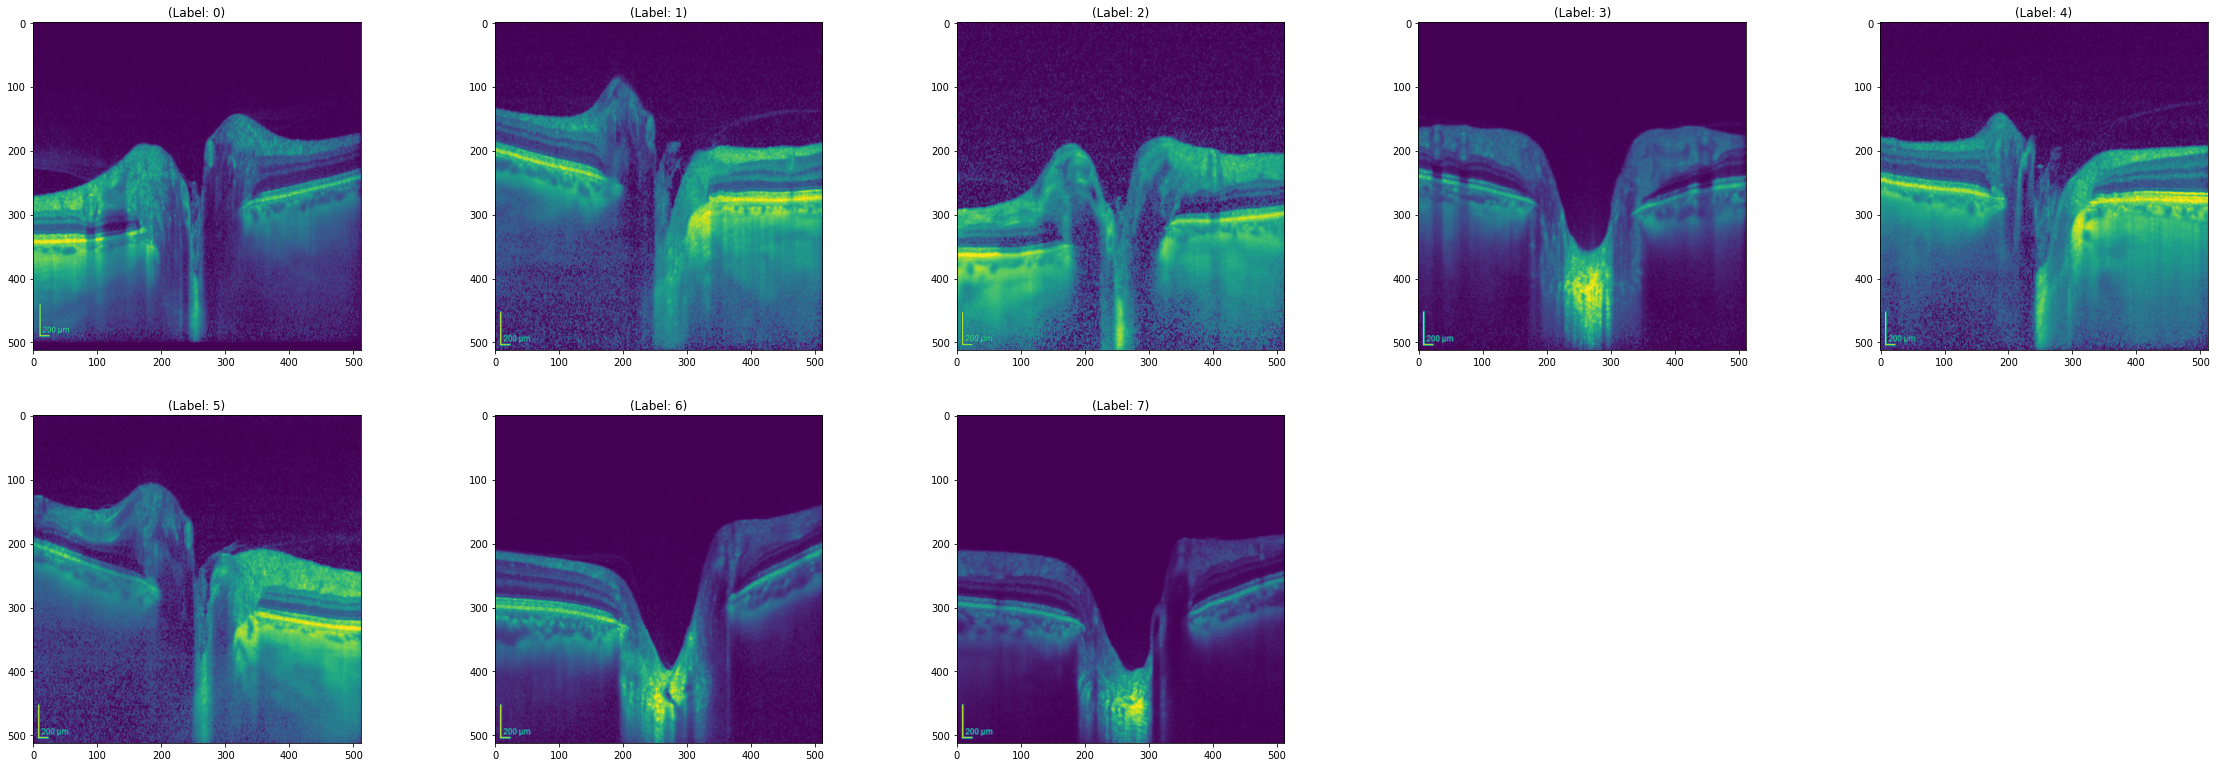

In [6]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(8):
    plt.subplot(14, 5, i+1)
    plt.imshow(train_images[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

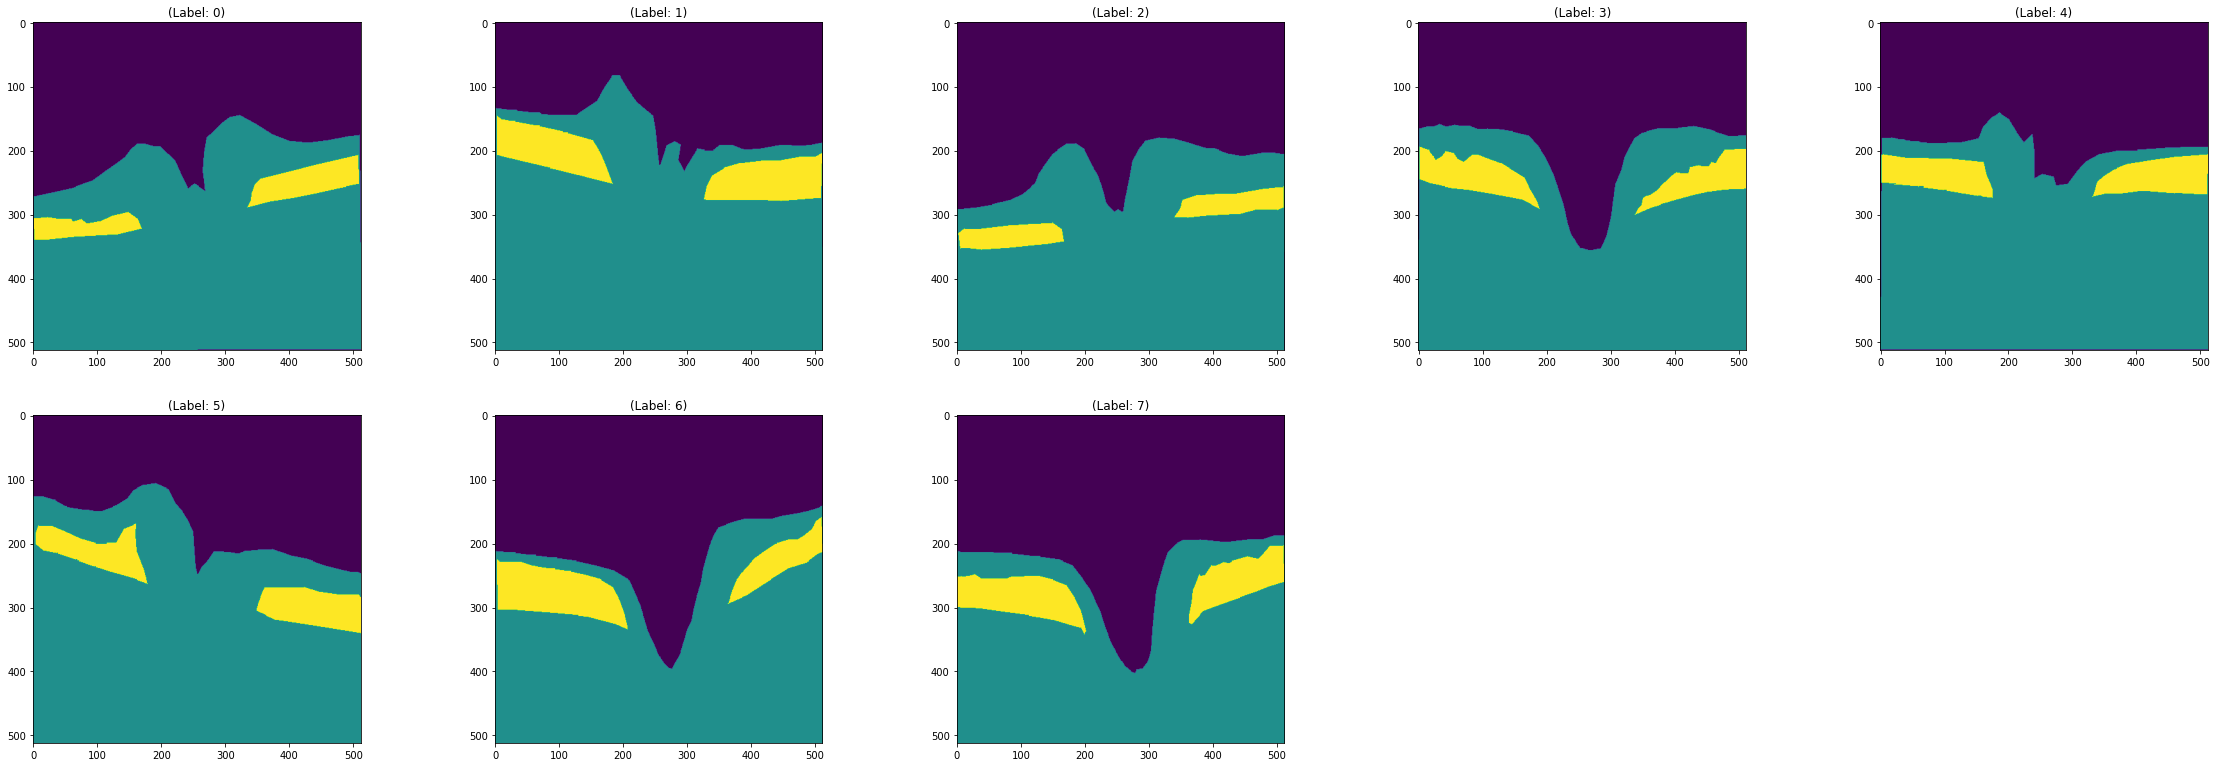

In [7]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(8):
    plt.subplot(14, 5, i+1)
    plt.imshow(train_masks[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

In [8]:

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)


#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


/home/khamituly/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Class values in the dataset are ...  [0 1 2]


In [9]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=SIZE_Y, IMG_WIDTH=SIZE_X, IMG_CHANNELS=1)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-05-26 13:06:46.298033: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-26 13:06:46.298081: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (daito): /proc/driver/nvidia/version does not exist
2022-05-26 13:06:46.298474: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

1/1 [==============================] - 0s 368ms/step


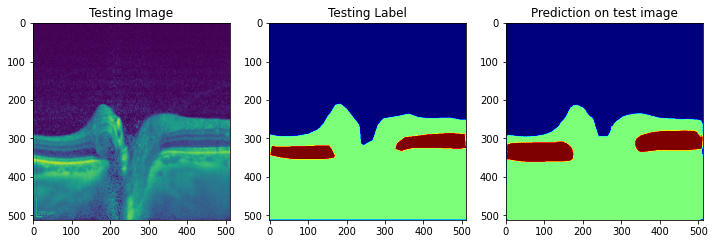

In [11]:
# Predict on a few images
model2 = get_model()
model2.load_weights('/home/khamituly/Documents/defense/for_defense/retina_segmentation_mentors_dataset.hdf5')  

import random
test_img_number = 5
test_img = X_train[test_img_number]
ground_truth= y_train[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

prediction = (model2.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()